In [1]:
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path

In [2]:
content_path = Path('/content/contentimage.jpg')
style_path = Path('/content/styleimage.jpg')

In [3]:


def load_img(path_to_img):
    '''Loads an image from a file path and resizes it to a maximum dimension of 512 pixels.'''
    max_dim = 512  # Maximum dimension for the longest side of the image
    image = tf.io.read_file(str(path_to_img))  # Read the image file as a binary string
    image = tf.image.decode_image(image, channels=3)  # Decode the binary string to an image tensor with 3 color channels (RGB)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32 dtype for processing

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)  # Get the shape of the image and cast it to float32
    long_dim = max(shape)  # Determine the longest side of the image
    scale = max_dim / long_dim  # Calculate the scaling factor

    new_shape = tf.cast(shape * scale, tf.int32)  # Compute the new shape by scaling the original dimensions

    image = tf.image.resize(image, new_shape)  # Resize the image to the new dimensions
    image = image[tf.newaxis, :]  # Add a batch dimension at the beginning
    image = tf.image.convert_image_dtype(image, tf.uint8)  # Convert the image back to uint8 dtype for display

    return image  # Return the processed image tensor

def load_images(content_path, style_path):
    '''Loads the content and style images from file paths as tensors.'''
    content_image = load_img(content_path)  # Load and process the content image
    style_image = load_img(style_path)  # Load and process the style image

    return content_image, style_image  # Return both images as tensors

def imshow(image, title=None):
    '''Displays an image using Matplotlib with an optional title.'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)  # Remove the batch dimension if it exists

    plt.imshow(image)  # Display the image
    plt.axis('off')  # Remove axis ticks and labels for a cleaner display
    if title:
        plt.title(title)  # Add a title if provided

def show_images_with_objects(images, titles=[]):
    '''Displays multiple images in a row with corresponding titles using Matplotlib.'''
    if len(images) != len(titles):
        return  # Ensure the number of images matches the number of titles

    plt.figure(figsize=(20, 12))  # Set the size of the figure
    for idx, (image, title) in enumerate(zip(images, titles)):  # Iterate over images and titles
        plt.subplot(1, len(images), idx + 1)  # Create a subplot for each image
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        imshow(image, title)  # Display the image with its title


In [4]:
K.clear_session()
tmp_inception = tf.keras.applications.InceptionV3()
del tmp_inception

96112376/96112376 [==============================] - 5s 0us/step


In [5]:
# Specify the layer to be used for content extraction and store it in a list
content_layers = ['conv2d_93']

# Specify the layers to be used for style extraction and store them in a list
style_layers = ['conv2d',      # Initial convolutional layer
                'conv2d_1',    # First convolutional layer after initial
                'conv2d_2',    # Second convolutional layer
                'conv2d_3',    # Third convolutional layer
                'conv2d_4']    # Fourth convolutional layer

# Combine the content and style layers into a single list
content_and_style_layers = style_layers + content_layers

# Count the number of content layers and store it in a variable
NUM_CONTENT_LAYERS = len(content_layers)

# Count the number of style layers and store it in a variable
NUM_STYLE_LAYERS = len(style_layers)


In [6]:
def inception_model(layer_names):
    """Builds an InceptionV3 model that outputs specified intermediate layers.

    Args:
    layer_names (list of str): Names of the layers to extract outputs from.

    Returns:
    tf.keras.Model: A model that provides outputs of the specified layers.
    """
    # Load InceptionV3 with ImageNet weights, excluding the top classification layer
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

    # Set all layers to non-trainable
    inception.trainable = False

    # Retrieve the outputs of the specified layers
    output_layers = [inception.get_layer(name).output for name in layer_names]

    # Create a new model that outputs the specified layers
    model = tf.keras.models.Model(inputs=inception.input, outputs=output_layers)

    # Return the new model
    return model


In [7]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
def get_style_loss(features, targets):

  # Calculate the style loss
  style_loss =  tf.reduce_mean(tf.square(features - targets))

  return style_loss

In [9]:
def get_content_loss(features, targets):
  # get the sum of the squared error multiplied by a scaling factor
  content_loss =  0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

In [10]:
def gram_matrix(input_tensor):

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations

  return scaled_gram

In [11]:
tmp_layer_list = [layer.output for layer in inception.layers]


In [12]:
def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

In [13]:
def get_style_image_features(image):

  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

In [14]:
def get_content_image_features(image):

  # preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

$L_{total} = \beta L_{style} + \alpha L_{content}$

In [15]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])
  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS
  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
  # sum up the style and content losses
  total_loss = style_loss + content_loss

  # return the total loss
  return total_loss

In [16]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight):
  with tf.GradientTape() as tape:

    # get the style image features
    style_features = get_style_image_features(image)
    # get the content image features
    content_features = get_content_image_features(image)
    # get the style and content loss
    loss =  get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

In [17]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [18]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):
  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight)
  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])
  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [19]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

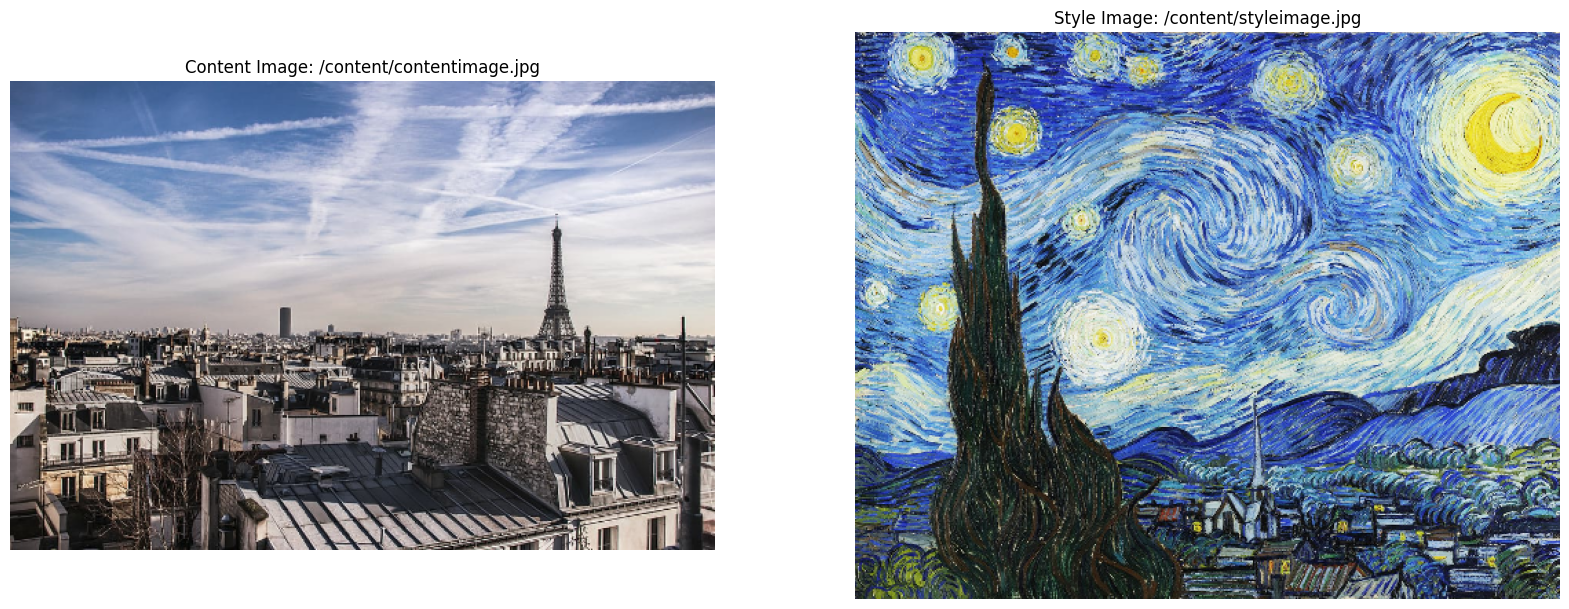

In [20]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  images = []
  step = 0

  # get the style image features
  style_targets = get_style_image_features(style_image)
  # get the content image features
  content_targets = get_content_image_features(content_image)
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  images.append(content_image)

  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      update_image_with_style(generated_image, style_targets, content_targets,
                              style_weight, content_weight, optimizer)

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)

    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    images.append(generated_image)
    print("Train step: {}".format(step))

  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images
content_image, style_image = load_images(content_path, style_path)

show_images_with_objects([content_image, style_image],
                         titles=[f'Content Image: {content_path}',
                                 f'Style Image: {style_path}'])

plt.show()


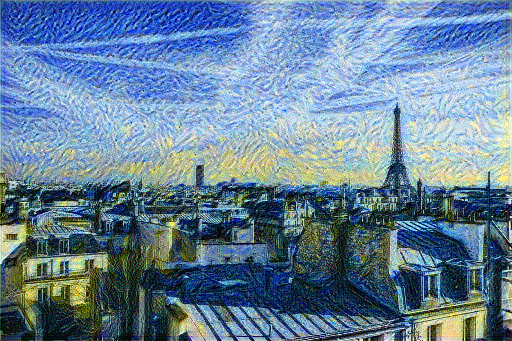

Train step: 1000


In [21]:

style_weight =  0.2
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)